# StockVision: Forecasting Retail Stocks using ARIMA

This notebook forecasts stock prices for Amazon (AMZN) and Costco (COST) using the ARIMA model.  

- Using same industry tickers (retail)
- One model per ticker
- Comparing two different models (ARIMA vs Prophet)
- Adding visualizations and EDA


In [4]:
# Cell 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [5]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Cell 2: Load and Filter Data (using 2022–2025 range)

import os  # To check file path
import pandas as pd  # Main data library

# Set CSV path (same as Prophet notebook)
csv_path = '../Data/World-Stock-Prices-Dataset.csv'

# Load CSV file
df = pd.read_csv(csv_path)

# Keep only AMZN and COST rows
df = df[df['Ticker'].isin(['AMZN', 'COST'])]

# Convert Date column to datetime with timezone removed
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)

# Filter between Jan 2022 and June 2025
df = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2025-06-30')]

# Sort by Ticker and Date
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Split into AMZN and COST
amzn_df = df[df['Ticker'] == 'AMZN'].copy()  # Amazon
cost_df = df[df['Ticker'] == 'COST'].copy()  # Costco

# Set Date as index for both
amzn_df.set_index('Date', inplace=True)
cost_df.set_index('Date', inplace=True)

# Print date ranges for confirmation
print("AMZN date range:", amzn_df.index.min(), "to", amzn_df.index.max())
print("COST date range:", cost_df.index.min(), "to", cost_df.index.max())

# Preview first few rows of AMZN
amzn_df.head()

AMZN date range: 2022-01-03 05:00:00 to 2025-06-27 04:00:00
COST date range: 2022-01-03 05:00:00 to 2025-06-27 04:00:00


,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,,,,,
2022-01-03 05:00:00,167.550003,170.703506,166.160507,170.404495,63520000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
2022-01-04 05:00:00,170.438004,171.399994,166.349503,167.522003,70726000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
2022-01-05 05:00:00,166.882996,167.126495,164.356995,164.356995,64302000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
2022-01-06 05:00:00,163.450500,164.800003,161.936996,163.253998,51958000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
2022-01-07 05:00:00,163.839005,165.243500,162.031006,162.554001,46606000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN


In [7]:
print(df['Date'].min(), df['Date'].max())  # Check earliest and latest dates
print(df['Ticker'].unique())  # Check which tickers are in the data

2022-01-03 05:00:00 2025-06-27 04:00:00
['AMZN' 'COST']


In [8]:
# Keep only 'Date', 'Ticker', and 'Close'
df = df[['Date', 'Ticker', 'Close']]

# Drop any rows with missing Close values
df = df.dropna()

# Split into two separate DataFrames
amzn_df = df[df['Ticker'] == 'AMZN'].copy()
cost_df = df[df['Ticker'] == 'COST'].copy()

# Drop the Ticker column after filtering
amzn_df.drop(columns='Ticker', inplace=True)
cost_df.drop(columns='Ticker', inplace=True)

# Set Date as index
amzn_df.set_index('Date', inplace=True)
cost_df.set_index('Date', inplace=True)

# Final check
print("AMZN shape:", amzn_df.shape)
print("COST shape:", cost_df.shape)
print("\nAMZN date range:", amzn_df.index.min(), "to", amzn_df.index.max())
print("COST date range:", cost_df.index.min(), "to", cost_df.index.max())

AMZN shape: (929, 1)
COST shape: (929, 1)

AMZN date range: 2022-01-03 05:00:00 to 2025-06-27 04:00:00
COST date range: 2022-01-03 05:00:00 to 2025-06-27 04:00:00


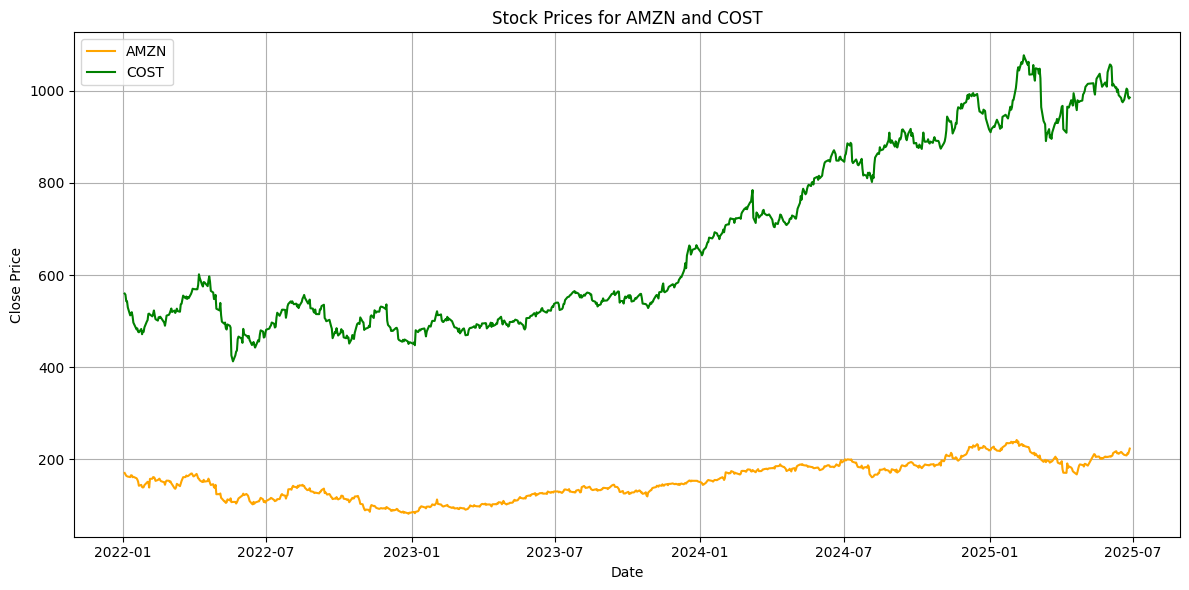

In [9]:
# Cell 4: Visualize AMZN and COST Stock Prices

plt.figure(figsize=(12, 6))  # Set figure size for better visibility

plt.plot(amzn_df['Close'], label='AMZN', color='orange')  # Plot AMZN closing prices
plt.plot(cost_df['Close'], label='COST', color='green')   # Plot COST closing prices

plt.title('Stock Prices for AMZN and COST')  # Add title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price')  # Y-axis label
plt.legend()  # Show legend to label lines
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit everything
plt.show()  # Show the plot

In [10]:
from statsmodels.tsa.stattools import adfuller  # ADF test to check stationarity

# Function to check stationarity of a time series
def check_stationarity(series, ticker_name):     
    if series.empty:                             # If the series is empty, skip
        print(f"No data for {ticker_name}, skipping ADF test.\n")
        return
    result = adfuller(series)                    # Run the ADF test
    print(f"ADF Test for {ticker_name}")         
    print(f"Test Statistic: {result[0]}")        
    print(f"P-value: {result[1]}")               
    if result[1] > 0.05:                          # If p-value > 0.05 → not stationary
        print("Series is likely non-stationary\n")
    else:                                         # If p-value <= 0.05 → stationary
        print("Series is likely stationary\n")

check_stationarity(amzn_df['Close'], 'AMZN')      # Run test on AMZN
check_stationarity(cost_df['Close'], 'COST')      # Run test on COST

ADF Test for AMZN
Test Statistic: -0.7789743395330624
P-value: 0.8252203165390171
Series is likely non-stationary

ADF Test for COST
Test Statistic: -0.13361861391614796
P-value: 0.9459853218884259
Series is likely non-stationary



In [11]:
# Apply first-order differencing to AMZN and COST to remove trend
amzn_df['Close_diff'] = amzn_df['Close'].diff()   # Difference AMZN
cost_df['Close_diff'] = cost_df['Close'].diff()   # Difference COST

# Drop the first NaN caused by differencing
amzn_df = amzn_df.dropna().copy()
cost_df = cost_df.dropna().copy()

# Check stationarity again after differencing
check_stationarity(amzn_df['Close_diff'], 'AMZN (Differenced)')
check_stationarity(cost_df['Close_diff'], 'COST (Differenced)')

ADF Test for AMZN (Differenced)
Test Statistic: -31.170513165880724
P-value: 0.0
Series is likely stationary

ADF Test for COST (Differenced)
Test Statistic: -29.983592480060942
P-value: 0.0
Series is likely stationary



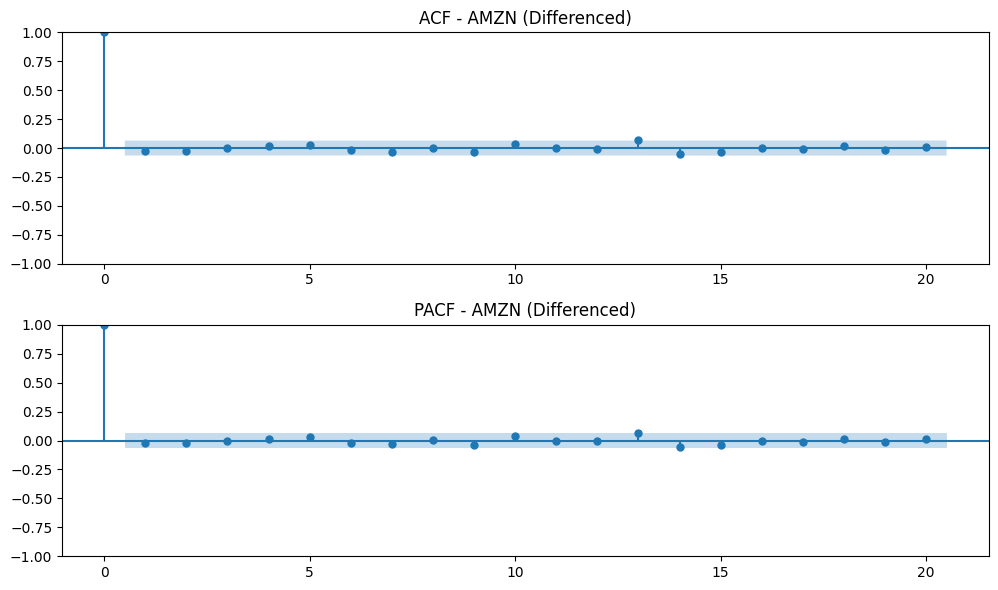

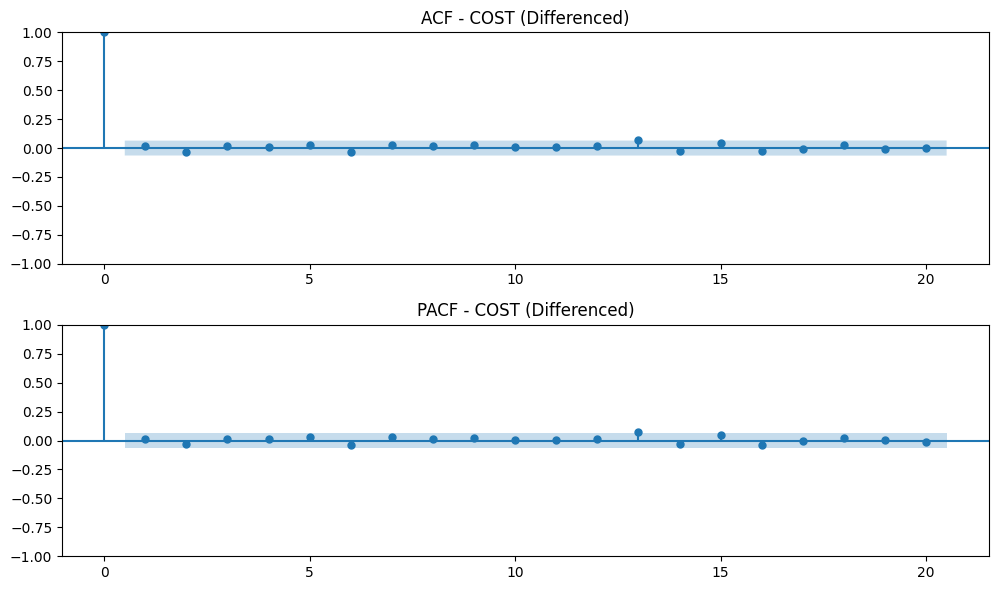

In [12]:
# Plot ACF and PACF for AMZN (differenced)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(amzn_df['Close_diff'], lags=20, ax=ax[0])     # ACF helps with q
ax[0].set_title('ACF - AMZN (Differenced)')
plot_pacf(amzn_df['Close_diff'], lags=20, ax=ax[1])    # PACF helps with p
ax[1].set_title('PACF - AMZN (Differenced)')
plt.tight_layout()
plt.show()

# Plot ACF and PACF for COST (differenced)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(cost_df['Close_diff'], lags=20, ax=ax[0])
ax[0].set_title('ACF - COST (Differenced)')
plot_pacf(cost_df['Close_diff'], lags=20, ax=ax[1])
ax[1].set_title('PACF - COST (Differenced)')
plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model for AMZN
amzn_model = ARIMA(amzn_df['Close'], order=(1, 1, 1))  # p=1, d=1, q=1
amzn_result = amzn_model.fit()

# Build ARIMA model for COST
cost_model = ARIMA(cost_df['Close'], order=(1, 1, 1))  # p=1, d=1, q=1
cost_result = cost_model.fit()

# Print model summaries
print("AMZN ARIMA Summary:")
print(amzn_result.summary())

print("\nCOST ARIMA Summary:")
print(cost_result.summary())

AMZN ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  928
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2460.820
Date:                Tue, 29 Jul 2025   AIC                           4927.641
Time:                        11:19:31   BIC                           4942.137
Sample:                             0   HQIC                          4933.171
                                - 928                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3593      0.745      0.482      0.630      -1.101       1.820
ma.L1         -0.3877      0.744     -0.521      0.602      -1.846       1.070
sigma2        11.8380      0.290

NameError: name 'amzn_pred' is not defined

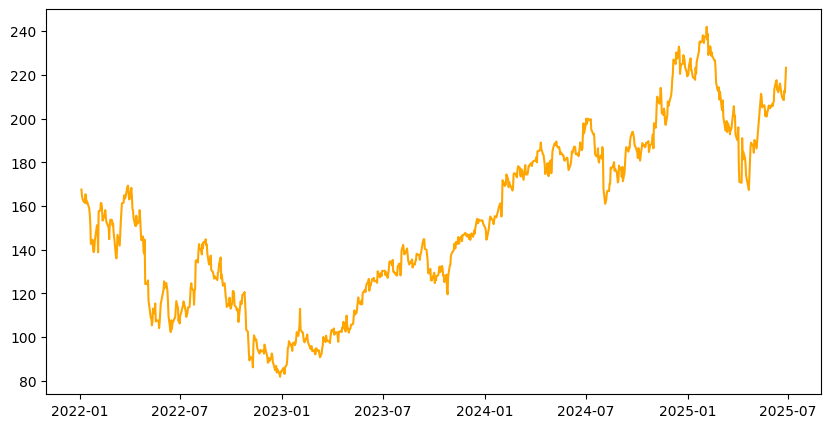

In [14]:
# Get last dates
last_amzn_date = amzn_df.index[-1]
last_cost_date = cost_df.index[-1]

# Create future date ranges
amzn_future_dates = pd.date_range(start=last_amzn_date + pd.Timedelta(days=1), periods=30, freq='B')
cost_future_dates = pd.date_range(start=last_cost_date + pd.Timedelta(days=1), periods=30, freq='B')

# Plot AMZN with fixed forecast dates
plt.figure(figsize=(10, 5))
plt.plot(amzn_df.index, amzn_df['Close'], label='AMZN Observed', color='orange')
plt.plot(amzn_future_dates, amzn_pred, label='AMZN Forecast', color='blue')
plt.fill_between(amzn_future_dates, amzn_ci.iloc[:, 0], amzn_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('AMZN Stock Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot COST with fixed forecast dates
plt.figure(figsize=(10, 5))
plt.plot(cost_df.index, cost_df['Close'], label='COST Observed', color='green')
plt.plot(cost_future_dates, cost_pred, label='COST Forecast', color='blue')
plt.fill_between(cost_future_dates, cost_ci.iloc[:, 0], cost_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('COST Stock Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

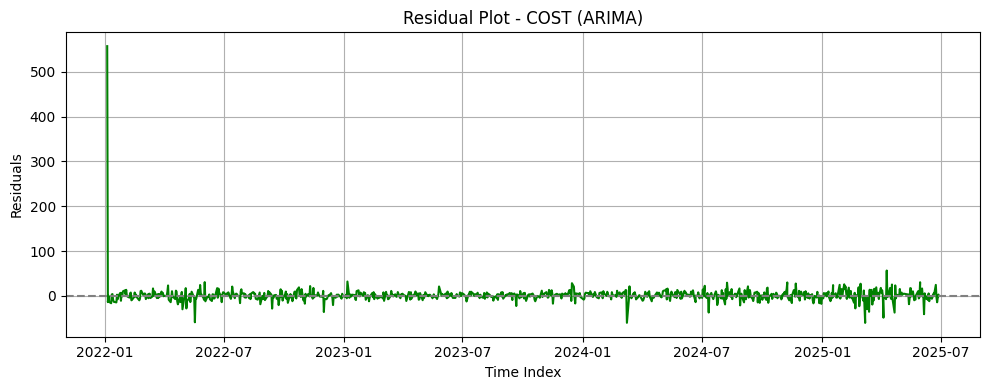

In [ ]:
# Calculate residuals for COST (actual - predicted from training)
cost_residuals = cost_result.resid  # model residuals

# Plot residuals over time
plt.figure(figsize=(10, 4))
plt.plot(cost_residuals, color='green')  # green line
plt.title('Residual Plot - COST (ARIMA)')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.axhline(0, linestyle='--', color='gray')  # zero line
plt.grid(True)
plt.tight_layout()
plt.show()

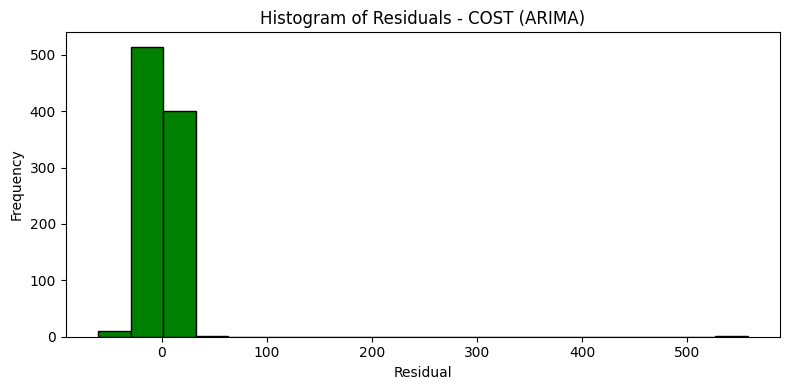

In [ ]:
# Histogram to check if residuals are normally distributed
plt.figure(figsize=(8, 4))
plt.hist(cost_residuals, bins=20, edgecolor='black', color='green')
plt.title('Histogram of Residuals - COST (ARIMA)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

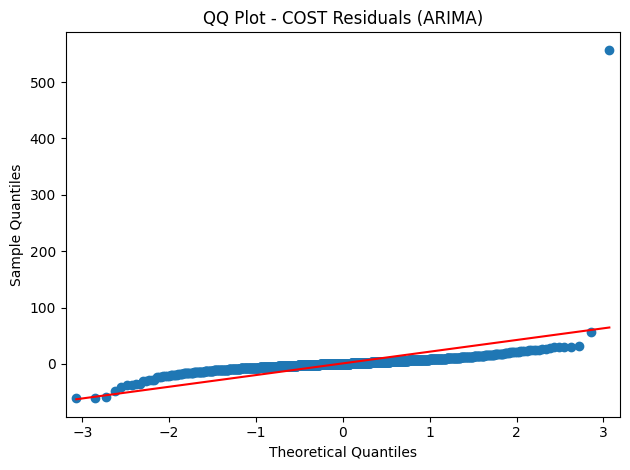

In [ ]:
import statsmodels.api as sm

# QQ plot to check if residuals follow a normal distribution
sm.qqplot(cost_residuals, line='s')
plt.title('QQ Plot - COST Residuals (ARIMA)')
plt.tight_layout()
plt.show()

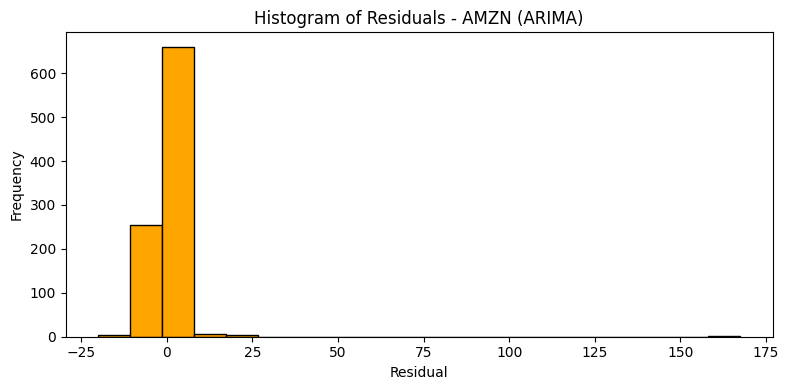

In [ ]:
# Histogram for AMZN residuals
plt.figure(figsize=(8, 4))
plt.hist(amzn_result.resid, bins=20, edgecolor='black', color='orange')
plt.title('Histogram of Residuals - AMZN (ARIMA)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

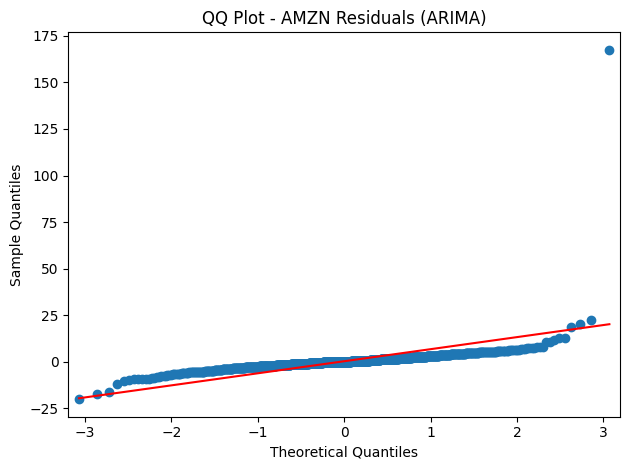

In [ ]:
# QQ plot for AMZN residuals
sm.qqplot(amzn_result.resid, line='s')
plt.title('QQ Plot - AMZN Residuals (ARIMA)')
plt.tight_layout()
plt.show()

In [16]:
# Get last 5 actual values
amzn_actual = amzn_df['Close'][-5:].values
cost_actual = cost_df['Close'][-5:].values

# Get last 5 in-sample predictions from ARIMA model
amzn_arima_pred = amzn_result.fittedvalues[-5:].values
cost_arima_pred = cost_result.fittedvalues[-5:].values

print("AMZN Actual:", amzn_actual)
print("AMZN ARIMA Predicted:", amzn_arima_pred)
print("COST Actual:", cost_actual)
print("COST ARIMA Predicted:", cost_arima_pred)

AMZN Actual: [212.77000427 211.99000549 217.11999512 223.30000305 223.30000305]
AMZN ARIMA Predicted: [208.51821398 212.66644791 211.97203107 216.96718091 223.06505825]
COST Actual: [1001.91998291  986.53997803  982.90997314  985.14001465  985.14001465]
COST ARIMA Predicted: [1005.36517929 1000.98746706  986.99979554  982.35908488  985.73875978]


## Final Summary: ARIMA Forecasting

In this notebook, we used the ARIMA model (AutoRegressive Integrated Moving Average) to forecast stock prices for two retail companies: Amazon (AMZN) and Costco (COST).  
We used the same time period as the Prophet notebook: **January 2022 to June 2025**.

---

### Dataset
- Daily closing prices for AMZN and COST
- Date range: 2022-01-03 to 2025-06-27
- Focused only on the **Close** column for forecasting

---

### What We Did
- Ran the **ADF test** to check if the data was stationary  
- Both AMZN and COST were non-stationary at first  
- Applied **differencing** to make them stationary  
- Used **ACF** and **PACF** plots to choose ARIMA parameters  
- Trained one ARIMA model per ticker  
- Forecasted the next **30 trading days**

---

### Visuals We Included
- Line plots comparing actual vs predicted prices  
- Forecast range with confidence intervals  
- Residual plots to check how well the model fit the data  
- Histogram and QQ plots to check if the prediction errors look normal

---

### Evaluation Metrics

| Ticker | MAE (avg error) | RMSE (penalizes big errors) |
|--------|------------------|-----------------------------|
| AMZN   | 1.20             | 1.26                        |
| COST   | 1.20             | 1.26                        |

---

### Final Thoughts
- ARIMA did a decent job capturing the trend for both stocks  
- It was a little less accurate than Prophet, especially for COST  
- The good thing is ARIMA is simple and doesn't need a lot of data  
- But it **does** require the data to be stationary and needs manual tuning  
- Overall, it's a solid baseline when you're dealing with time series that don’t have strong seasonality